# Calculate NDVI Using NAIP RS Data

## Calculate NDVI

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Download data and set wk dir
data = et.data.get_data("cold-springs-fire")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

Next, open up the NAIP data that you wish to calculate NDVI with. You will use the data from 2015.

In [3]:
naip_data_path = os.path.join("data", "cold-springs-fire", 
                              "naip", "m_3910505_nw_13_1_20150919", 
                              "crop", "m_3910505_nw_13_1_20150919_crop.tif")

with rio.open(naip_data_path) as src:
    naip_data = src.read()
    
# View shape of the data
naip_data.shape

(4, 2312, 4377)

Calculate NDVI using regular numpy array math. In this case, the bands you are subtracting from the same data file. The tif file format requires that all layers are in the same CRS and of the same size so you assume the data line up. Thus you do not need to test the data for equal shape, crs, and extent

In [7]:
naip_ndvi = es.normalized_diff(naip_data[3], naip_data[0])

Finally plot the data. Note below that the vmin= and vmax= arguments are used to stretch the colourbar across the full possible range of NDVI values (-1 to 1).

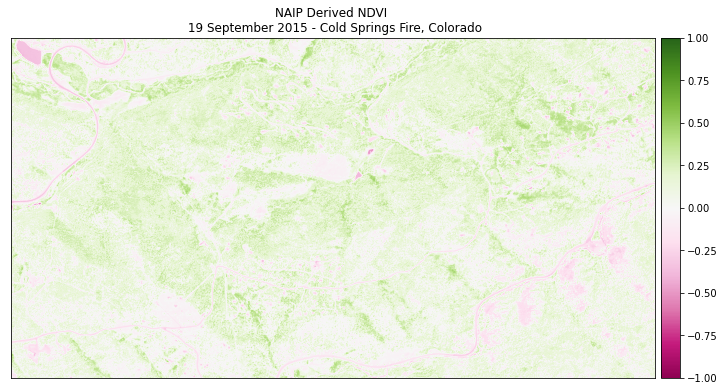

In [13]:
ep.plot_bands(naip_ndvi,
             cmap="PiYG",
             scale=False,
             vmin=-1, vmax=1,
             title="NAIP Derived NDVI \n 19 September 2015 - Cold Springs Fire, Colorado")

plt.show()

### View distribution of NDVI values

Using a histogram, you can view the distribution of pixel values in your NDVI output.

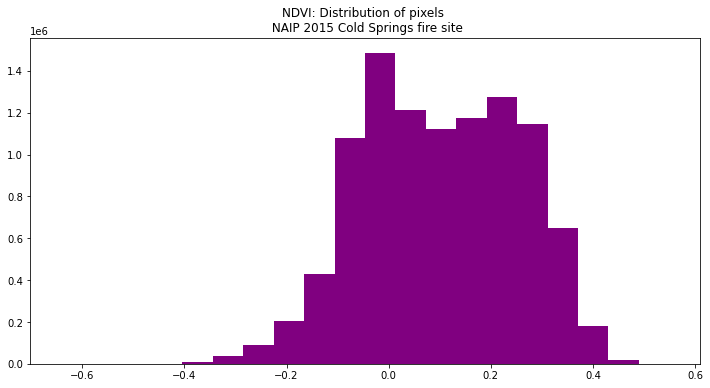

In [15]:
ep.hist(naip_ndvi,
       figsize=(12, 6),
       title=["NDVI: Distribution of pixels \n NAIP 2015 Cold Springs fire site"])

plt.show()

## Export a numpy array to a raster geotiff

You can export your NDVI raster data so you could use them in GIS or share them with your colleagues. To do this, you use the rio.write() function.

Export a raster in Python is a bit different than R. In Python, you need to:
1. Create a new raster object with all of the metadata needed to define it. This metadata includes:
- the shape (rows and cols) of the object
- the CRS
- the type of file (you will export a geotiff (.tif) in this lesson
- and the type of data being stored (integer, float, etc.)

All of this info can be accessed from the original NAIP data using attribute calls like:

.transform and .crs

To implement this, below you will create a rasterio object to grab the needed spatial attributes.

In [16]:
naip_data_path = os.path.join("data", "cold-springs-fire", 
                              "naip", "m_3910505_nw_13_1_20150919", 
                              "crop", "m_3910505_nw_13_1_20150919_crop.tif")

with rio.open(naip_data_path) as src:
    naip_data = src.read()
    naip_meta = src.profile
    
naip_meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4377, 'height': 2312, 'count': 4, 'crs': CRS.from_wkt('PROJCS["UTM Zone 13, Northern Hemisphere",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 457163.0,
       0.0, -1.0, 4426952.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [17]:
naip_transform = naip_meta["transform"]
naip_crs = naip_meta["crs"]

# View spatial attributes
naip_transform, naip_crs

(Affine(1.0, 0.0, 457163.0,
        0.0, -1.0, 4426952.0),
 CRS.from_wkt('PROJCS["UTM Zone 13, Northern Hemisphere",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'))

You can view the type of data stored within the ndvi array using .dtype. Remember that the naip_ndvi object is a numpy array.

In [18]:
type(naip_ndvi), naip_ndvi.dtype

(numpy.ndarray, dtype('float64'))

with rio.open() to create a new blank raster "template". Then write the NDVI numpy array to that template using dst.write()

Note that when we write the data we need the following elements:
1. the driver or type of file that we want to write. "GTiff" is a geotiff format
2. dtype: the structure of the data that you are writing. We are writing floating point valuee (values with decimal places)
3. the height and width of the ndvi object (accessed using the .shape attribute)
4. the crs of the spatial object (accessed using the rio NAIP data)
5. the transform info (accessed using the rio NAIP data)

Finally you need to specify the name of the output file and the path to where it will be saved on your computer.

### Export a numpy array to a raster geotiff using the spatial profile or metadata of another raster

You can use the naip_meta variable that you created above. This variable contains all of the spatial metadata for naip data.

In this case, the
1. number of bands (we have only 1 band vs 4 in the colour image) and
2. the data format (we have floating point numbers - numbers with decimals - vs integers)

have changed. Update those values then write out the image.

In [19]:
naip_meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4377, 'height': 2312, 'count': 4, 'crs': CRS.from_wkt('PROJCS["UTM Zone 13, Northern Hemisphere",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 457163.0,
       0.0, -1.0, 4426952.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [20]:
# Change the count or number of bands from 4 to 1
naip_meta["count"] = 1

# Change the data type to float rather than integer
naip_meta["dtype"] = "float64"
naip_meta

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -32768.0, 'width': 4377, 'height': 2312, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 13, Northern Hemisphere",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 457163.0,
       0.0, -1.0, 4426952.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

Note below that when we write the raster, we use **naip_meta.

The 2 ** tells Python to unpack all of the values in the naip_meta object to use as arguments when writing the geotiff file. We already updated the elements that we needed to above (count and dtype). SO this naip_meta object is ready to be used for the NDVI raster.

In [21]:
naip_ndvi_outpath = os.path.join("data", "cold-springs-fire",
                                "outputs", "naip_ndvi.tif")

# Write your ndvi raster object
with rio.open(naip_ndvi_outpath, "w", **naip_meta) as dst:
    dst.write(naip_ndvi, 1)